# MS4610 Introduction to Data Analytics || Course Project 
### Final Attempt
Notebook by **Group 12**

Here were generate some new features, and use the models which have been performing well so far. Let's see what happens.

In [35]:
# Data and image handling libraries

import numpy as np
import pandas as pd
from glob import glob
import cv2

# Classifiers

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier

# Data preprocessing functions

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox

# Evaluation metrics

from sklearn.metrics import roc_auc_score 
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

# Plotting libraries

import matplotlib.pyplot as plt

# Others

import statistics as stats
from IPython.display import clear_output
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
# Load datasets

train = pd.read_csv(".././mod_data/train.csv")
data_dict = pd.read_csv(".././data/Data_Dictionary.csv")

In [7]:
# Add our column names to data dictionary

col_names = train.columns.tolist()
data_dict['col_names'] = col_names
data_dict = data_dict[['Name', 'Definition', 'col_names']]

In [11]:
data_dict

,Name,Definition,col_names
0,application_key,Application ID (primary key),application_key
1,mvar1,Credit worthiness score calculated on the basi...,credit_score
2,mvar2,A score calculated based on the number and ris...,risk_score
3,mvar3,Severity of default by the borrower on any loa...,sev_def_any
4,mvar4,Severity of default by the borrower on auto lo...,sev_def_auto
5,mvar5,Severity of default by the borrower on educati...,sev_def_edu
6,mvar6,Minimum of credit available on all revolving c...,min_credit_rev
7,mvar7,Maximum of credit available on all active cred...,max_credit_act
8,mvar8,Maximum of credit available on all active revo...,max_credit_act_rev
9,mvar9,Sum of available credit on credit cards that t...,total_credit_1_miss


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83000 entries, 0 to 82999
Data columns (total 61 columns):
application_key           83000 non-null float64
credit_score              83000 non-null float64
risk_score                83000 non-null float64
sev_def_any               83000 non-null float64
sev_def_auto              83000 non-null float64
sev_def_edu               83000 non-null float64
min_credit_rev            83000 non-null float64
max_credit_act            83000 non-null float64
max_credit_act_rev        83000 non-null float64
total_credit_1_miss       83000 non-null float64
total_credit              83000 non-null float64
due_collected             83000 non-null float64
total_due                 83000 non-null float64
annual_pay                83000 non-null float64
annual_income             83000 non-null float64
property_value            83000 non-null float64
fc_cards_act_rev          83000 non-null float64
fc_cards_act              83000 non-null float64
fc_lines_

In [21]:
# Imputation for each column
# Garbage cols will be imputed after deskewing

garbage_cols = ['credit_score', 'risk_score', 'total_credit_1_miss', 'total_credit', 'stress_index']
zero_cols = ['due_collected', 'total_due', 'annual_pay', 'fc_cards_act', 'fc_cards_act_rev', 'fc_lines_act', 
             'pc_cards_act', 'pc_lines_act', 'last_miss_time', 'lines_act_1_miss', 'cards_rev_1_miss',
             'lines_deli', 'lines_high_risk', 'mort_2_miss', 'auto_2_miss']
mean_cols = ['sev_def_any', 'sev_def_auto', 'sev_def_edu', 'annual_income', 'property_value', 'loan_util_act_rev',
             'line_util_past2', 'line_util_past1', 'line_util_1_miss', 'max_tenure_auto', 'max_tenure_edu',
             'total_tenure_act', 'residence_time', 'line_util_edu', 'line_util_auto', 'max_due_ratio'] 
min_cols = ['min_credit_rev', 'tenure_act_rev', 'tenure_oldest_act', 'tenure_oldest_act_rev', 'tenure_oldest_line', 'lines_act', 
            'cards_act_t2', 'lines_act_2yrs']
max_cols = ['max_credit_act', 'max_credit_act_rev']

# Impute
for col in garbage_cols:
    train[col] = train[col].fillna(-99999)

for col in zero_cols:
    train[col] = train[col].fillna(0)
    
for col in mean_cols:
    train[col] = train[col].fillna(train[col].mean())
    
for col in min_cols:
    train[col] = train[col].fillna(train[col].min())
    
for col in max_cols:
    train[col] = train[col].fillna(train[col].max())

In [25]:
# Creating some new features

train['avg_sev_def'] = train[['sev_def_any', 'sev_def_auto', 'sev_def_edu']].sum(axis=1)
train['due_income_ratio'] = train['total_due']/train['annual_income']
train['credit_lines_safe'] = train['lines_act'] + train['lines_act_2yrs'] - train['lines_high_risk']
train['avg_efficiency'] = train['annual_pay']/train['annual_income']
train['predictable_due_factor'] = (train['max_credit_act_rev']-train['min_credit_rev'])*train['stress_index']
train['due_risk'] = train['total_due'] * train['stress_index']
train['avg_total_line_util'] = train[['loan_util_act_rev', 'line_util_past2', 'line_util_past1']].sum(axis=1)
train['services_1_miss'] = train['lines_act_1_miss'] + train['cards_rev_1_miss']
train['services_in_use'] = train[['lines_act', 'cards_act_t2', 'lines_act_2yrs']].sum(axis=1)
train['total_line_util'] = train[['line_util_edu', 'line_util_auto']].sum(axis=1)
train['two_missed_pays'] = train[['mort_2_miss', 'auto_2_miss']].sum(axis=1)

In [27]:
# Imputing missing values in new features

train = train.drop('avg_efficieny', axis=1)
train[['due_income_ratio', 'avg_efficiency']] = train[['due_income_ratio', 'avg_efficiency']].fillna(0)

In [36]:
# Boxcox transformations to deskew some columns

skewed_orig = ['mvar1','mvar6','mvar7','mvar8','mvar9','mvar10',
               'mvar11','mvar12','mvar13','mvar14','mvar15','mvar21',
               'mvar22','mvar23','mvar24','mvar25','mvar26','mvar27',
               'mvar28','mvar29','mvar30','mvar31','mvar34']
skewed_new = ['avg_total_line_util', 'total_line_util', 'due_risk', 'predictable_due_factor', 'avg_sev_def']

skew_cols = []
for col in skewed_orig:
    skew_cols.append(data_dict.loc[data_dict['Name']==col, 'col_names'].values[0])
skew_cols += skewed_new

def normalize(df, X):
    df[X][df[X] < 0] = 0
    df[X][df[X] > df[X].quantile(0.99)] = df[X].quantile(0.99)
    df[X] = df[X].apply(lambda x: x + np.random.rand())
    df[X] = df[X].apply(lambda x: x + 1)
    
    df[X], _ = boxcox(df[X])
    
for col in skew_cols:
    normalize(train, col)

## Model Selection
Testing models on this data.

In [48]:
# LightGBM Classifier

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=300,
                       max_depth=9,
                       learning_rate=0.05, 
                       objective='binary',
                       scale_pos_weight=2.20,
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
auc_score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
acc_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
bal_acc_score = cross_val_score(model, X, y, cv=5, scoring='balanced_accuracy')
f_score = cross_val_score(model, X, y, cv=5, scoring='f1')
print("ROC-AUC Score (no CV): {}".format(np.mean(auc_score)))
print("Accuracy Score (no CV): {}".format(np.mean(acc_score)))
print("Balanced Accuracy Score (no CV): {}".format(np.mean(bal_acc_score)))
print("F1 Score: {}".format(np.mean(f_score)))
print('')
print(classification_report(y_val, preds))

# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

ROC-AUC Score (no CV): 0.790536889656
Accuracy Score (no CV): 0.740180722892
Balanced Accuracy Score (no CV): 0.715080707388
F1 Score: 0.592013312254

              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81     11829
         1.0       0.54      0.65      0.59      4771

   micro avg       0.74      0.74      0.74     16600
   macro avg       0.69      0.71      0.70     16600
weighted avg       0.76      0.74      0.75     16600



In [49]:
model.feature_importances_

array([333, 471,  83,  53,  86, 227, 223, 175, 166, 194, 227, 187, 193,
       257, 223,  16,  25,  51,  53,  52, 185, 193, 189, 203, 201, 133,
       131, 186, 226, 229, 226, 145, 215, 242,  29,  73, 111,  75,  20,
       140,  72, 110, 127, 170,  13,   3, 206, 341, 158, 126, 156, 245,
       162, 140,  79,  75, 193,  56, 121], dtype=int32)

<BarContainer object of 59 artists>

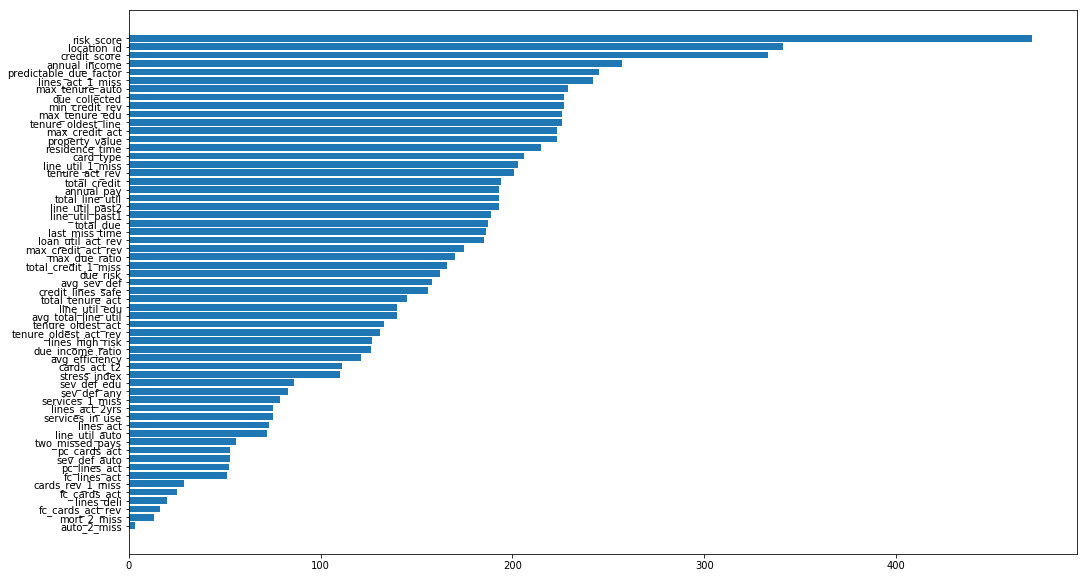

In [57]:
ranks = np.argsort(model.feature_importances_)
feat_imp = np.sort(model.feature_importances_)
cols = train.drop(['application_key', 'default_ind'], axis=1).columns[ranks].tolist()

plt.figure(figsize=(17,10))
plt.barh(cols, feat_imp)